# <center> Evaluate Learned primal dual </center>

In [1]:
import adler
adler.util.gpu.setup_one_gpu(0)

from adler.odl.phantom import random_phantom
from adler.tensorflow import prelu, cosine_decay

import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow
import warnings
warnings.filterwarnings('ignore')

Picking GPU 0


In [23]:
import os
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]+'/checkpoints'

In [3]:
np.random.seed(0)
import os
name = os.path.splitext(os.getcwd())[0]

sess = tf.InteractiveSession()

**Define space**

In [4]:
# Create ODL data structures
size = 128
space = odl.uniform_discr([-64, -64], [64, 64], [size, size],
                          dtype='float32')

In [5]:
# Using as backend scikit-image
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=30)
operator= odl.tomo.RayTransform(space, geometry)

In [6]:
# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [7]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint,
                                                                  'RayTransformAdjoint')

In [8]:
# User selected paramters
n_data = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [9]:
def generate_data(validation=False):
    """Generate a set of random data."""
    n_generate = 1 if validation else n_data

    y_arr = np.empty((n_generate, operator.range.shape[0], operator.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom = random_phantom(space)
        data = operator(phantom)
        noisy_data = data + odl.phantom.white_noise(operator.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [10]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, 1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator.range.shape[0], operator.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

In [11]:
def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

In [12]:
primal_values = []
dual_values = []

In [13]:
with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            #update = prelu(apply_conv(update), name='prelu_1')
            #update = prelu(apply_conv(update), name='prelu_2')
            update = tf.sigmoid(apply_conv(update))
            update = tf.sigmoid(apply_conv(update))
            update = apply_conv(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            #update = prelu(apply_conv(update), name='prelu_1')
            #update = prelu(apply_conv(update), name='prelu_2')
            update = tf.sigmoid(apply_conv(update))
            update = tf.sigmoid(apply_conv(update))
            update = apply_conv(update, filters=n_primal)
            primal = primal + update

        primal_values.append(primal)
        dual_values.append(dual)

    x_result = primal[..., 0:1]

In [16]:
# Initialize all TF var\iables
sess.run(tf.global_variables_initializer())

In [24]:
ckp_name = name+'_lpd_sigmoid/checkpoints'

In [26]:
adler.tensorflow.util.default_checkpoint_path(ckp_name)

'/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/checkpoints_lpd_sigmoid/checkpoints.ckpt'

In [27]:
# Add op to save and restore
saver = tf.train.Saver()

if 1:
    saver.restore(sess,
                  adler.tensorflow.util.default_checkpoint_path(ckp_name))

INFO:tensorflow:Restoring parameters from /store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/checkpoints_lpd_sigmoid/checkpoints.ckpt


In [28]:
# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data(validation=True)

primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                      feed_dict={x_true: x_true_arr_validate,
                                 y_rt: y_arr_validate,
                                 is_training: False})

Functions that take output of shape `[size_x,size_y,n_{Shearlets}]` and maps it to image using `shearsyn`:

In [29]:
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

print(ssim(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0]))
print(psnr(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0], data_range=1))

0.987473571059
38.2487624176


#### Saving images

In [20]:
path2img = '/homes/extern/andrade/store/GitHub_repos/tfshearlab/paper_figures/'

(-0.5, 127.5, 127.5, -0.5)

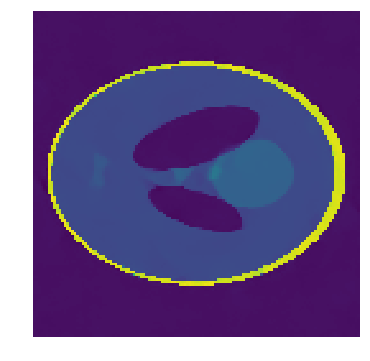

In [30]:
plt.figure(figsize=(6,6))
plt.imshow(primal_values_result[-1][0, ..., 0])
plt.axis('off')
#plt.savefig(path2img+'lpd_results.png', transparent = True, bbox_inches = 'tight', pad_inches = 0.0)

(-0.5, 127.5, 127.5, -0.5)

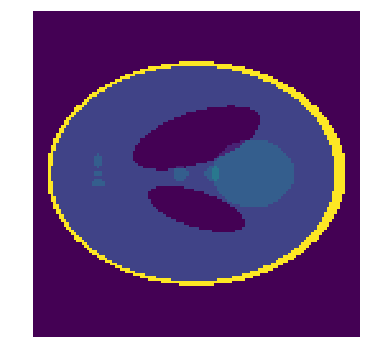

In [31]:
plt.figure(figsize=(6,6))
plt.imshow(x_true_arr_validate[0, ..., 0])
plt.axis('off')
#plt.savefig(path2img+'gt.png', transparent = True, bbox_inches = 'tight', pad_inches = 0.0)